In [1]:
import xgboost as xgb
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")

%pylab inline


%config InlineBackend.figure_formats = ['retina']


Populating the interactive namespace from numpy and matplotlib


## Access information in CSV - Info through 2019 from Kaggle, 2020 info from online, Week 8 spreads from CBS Sports App.

In [2]:
df=pd.read_csv('/Users/gavin/Documents/Metis/Coursework/Project_3/final_notebook/NFL_week_data_v3.csv')

In [3]:
df.dtypes

schedule_date                   object
schedule_season                  int64
schedule_week                    int64
target                          object
target_score                   float64
opponent_score                 float64
opponent                        object
target_spread                  float64
opponent_spread                float64
target_games_played            float64
opponent_games_played          float64
target_off_points_scored       float64
opponent_off_points_scored     float64
target_def_points_against      float64
opponent_def_points_against    float64
Won_game                       float64
won_spread                     float64
lost_game                      float64
lost_spread                    float64
win_percent                     object
win_spread_percent              object
opponent_win_percentage         object
opponent_spread_percentage      object
dtype: object

## Feature Engineering

Features: 

1. target points per game ÷ opponent points per game ÷ (150-spread) (offense outscoriong vs. expectation)

2. target points against per game ÷ opponent points against per game ÷ (150-spread) (defensive outperformance vs. expectation)

3. Win percentage against the spread

4. is the target the favorite?

In [4]:
df['win_percent']=df['win_percent'].apply(float)
df['win_spread_percent']=df['win_spread_percent'].apply(float)
df['opponent_win_percentage']=df['opponent_win_percentage'].apply(float)
df['opponent_spread_percentage']=df['opponent_spread_percentage'].apply(float)

In [5]:
df['target_favorite']=0
df.loc[df['target_spread']<0, 'target_favorite']=1

In [6]:
df['target_off_points_game'] = df['target_off_points_scored']/df['target_games_played']
df['opponent_off_points_game'] = df['opponent_off_points_scored']/df['opponent_games_played']
df['target_def_points_against_game'] = df['target_def_points_against']/df['target_games_played']
df['opponent_def_points_against_game'] = df['opponent_def_points_against']/df['opponent_games_played']

In [7]:
df['target_score_spread_adj'] = df['target_score']+df['target_spread']
df['beat_spread']=0
df.loc[df['target_score_spread_adj']>df['opponent_score'], 'beat_spread'] = 1

'spread impactor' is 150-spread, adjusts for negative/positive nature of spread

In [8]:
df['off_spread_impactor'] = 150-df['target_spread']
df['def_spread_impactor'] = 150-df['target_spread']

In [9]:
df['win_percent_SI'] = df['win_percent']/df['opponent_win_percentage']/df['off_spread_impactor']
df['win_spread_percent_SI'] = df['win_spread_percent']/df['opponent_spread_percentage']/df['off_spread_impactor']

In [10]:
df['off_points_SI'] = df['target_off_points_game']/df['opponent_off_points_game']/df['off_spread_impactor']*100
df['def_points_SI'] = df['target_def_points_against_game']/df['opponent_def_points_against_game']/df['def_spread_impactor']*100

Removing week 8, whose games have not yet occured:

In [178]:
df_predict = df[(df['schedule_season']==2020) & (df['schedule_week']==8)].copy()
df_run = df[(df['schedule_season']!=2020) | (df['schedule_week']!=8)].copy()

In [180]:
df_run.loc[df_run['win_percent_SI']==np.inf, 'win_percent_SI']=0
df_run.loc[df_run['win_spread_percent_SI']==np.inf, 'win_spread_percent_SI']=0

In [610]:
df_predict.to_csv('/Users/gavin/documents/metis/coursework/project_3/final_package/week_8.csv')

In [631]:
df_predict['opponent']

2770       Carolina Panthers
2771         Atlanta Falcons
2772           Detroit Lions
2773      Indianapolis Colts
2774          Miami Dolphins
2775        Los Angeles Rams
2776        Cleveland Browns
2777         Oakland Raiders
2778       Green Bay Packers
2779       Minnesota Vikings
2780           Buffalo Bills
2781    New England Patriots
2782      Kansas City Chiefs
2783           New York Jets
2784        Baltimore Ravens
2785     Pittsburgh Steelers
2786      Cincinnati Bengals
2787        Tennessee Titans
2788          Denver Broncos
2789    Los Angeles Chargers
2790           Chicago Bears
2791      New Orleans Saints
2792        Seattle Seahawks
2793     San Francisco 49ers
2794     Philadelphia Eagles
2795          Dallas Cowboys
2796         New York Giants
2797    Tampa Bay Buccaneers
Name: opponent, dtype: object

Because features are calculated on a per-year basis (and therefore restarts at the beginning of each year, model requires a few weeks to build a pattern of winning and losing. Therefore, we begin at week 7.

In [ ]:
df_run3 = df_run[df_run['schedule_week']>6]

In [461]:
df_run3.isnull().sum()

schedule_date                       0
schedule_season                     0
schedule_week                       0
target                              0
target_score                        0
opponent_score                      0
opponent                            0
target_spread                       0
opponent_spread                     0
target_games_played                 0
opponent_games_played               0
target_off_points_scored            0
opponent_off_points_scored          0
target_def_points_against           0
opponent_def_points_against         0
Won_game                            0
won_spread                          0
lost_game                           0
lost_spread                         0
win_percent                         0
win_spread_percent                  0
opponent_win_percentage             0
opponent_spread_percentage          0
target_favorite                     0
target_off_points_game              0
opponent_off_points_game            0
target_def_p

Establish X (features) and y

In [558]:
#'target_favorite', ,'def_points_SI','target_favorite''win_percent_SI'
X=df_run3[['off_points_SI', 'win_spread_percent_SI','def_points_SI', 'target_favorite']]
y=df_run3['beat_spread']

## Regressions

XGBoost:

In [559]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score

#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=10)

In [560]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=3,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=8,
                        colsample_bytree=.8
                       )

eval_set=[(X_train,y_train),(X_val,y_val)]
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=True
                   )

accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit)) 

[0]	validation_0-auc:0.59437	validation_1-auc:0.48015
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.60696	validation_1-auc:0.49003
[2]	validation_0-auc:0.61391	validation_1-auc:0.47211
[3]	validation_0-auc:0.61986	validation_1-auc:0.48088
[4]	validation_0-auc:0.62912	validation_1-auc:0.48214
[5]	validation_0-auc:0.62643	validation_1-auc:0.47385
[6]	validation_0-auc:0.63678	validation_1-auc:0.48248
[7]	validation_0-auc:0.64244	validation_1-auc:0.49125
[8]	validation_0-auc:0.64148	validation_1-auc:0.49733
[9]	validation_0-auc:0.64281	validation_1-auc:0.50445
[10]	validation_0-auc:0.65223	validation_1-auc:0.50577
[11]	validation_0-auc:0.65784	validation_1-auc:0.50558
[12]	validation_0-auc:0.65785	validation_1-auc:0.50621
[13]	validation_0-auc:0.65503	validation_1-auc:0.50940
[14]	validation_0-auc:0.65916	validation_1-auc:0.50949
[15]	validation_0-auc:0.6640

0.5898203592814372

Pickling for transfered use in streamlit

In [607]:
import pickle
outfile = open('nfl_xgb.pkl', 'wb')
pickle.dump(gbm, outfile)
outfile.close()

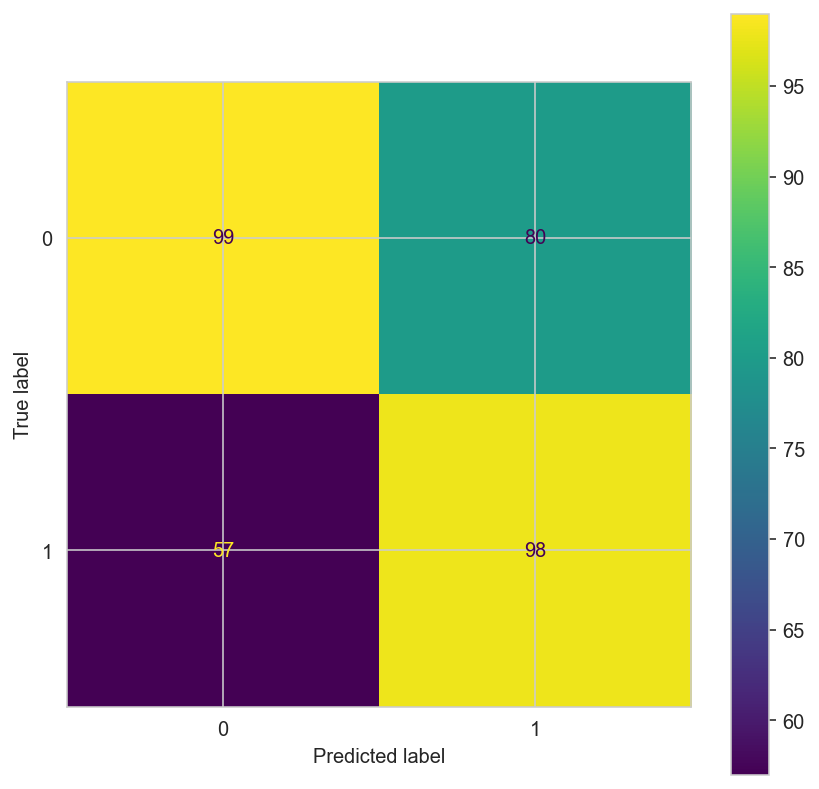

In [640]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(gbm, X_test, y_test, ax=ax);

In [561]:
test=gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit)

In [562]:
df_test = X_test.reset_index(drop=True)

In [563]:
df_test['beat_spread']=y_test.reset_index(drop=True)

In [564]:
df_test['prediction'] = test

Inspecting prediction:

In [565]:
df_test[df_test['prediction']==1]

,off_points_SI,win_spread_percent_SI,def_points_SI,target_favorite,beat_spread,prediction
1,0.759706,0.011182,0.502054,1,1,1
2,0.448491,0.002019,0.636819,0,1,1
3,0.709352,0.003268,0.600240,1,1,1
4,0.816837,0.005112,0.520968,1,1,1
7,0.701304,0.004892,0.675484,0,1,1
...,...,...,...,...,...,...
326,0.870266,0.031373,0.599009,1,1,1
328,0.525178,0.005757,0.559701,1,1,1
329,0.604575,0.005594,0.974907,0,0,1
330,0.524654,0.005447,0.462963,1,1,1


In [ ]:
precision calc:

In [566]:
df_test[df_test['prediction']==1].beat_spread.sum()

98

In [567]:
98/178

0.550561797752809

In [627]:
X_pred = df_predict[['target','off_points_SI', 'win_spread_percent_SI','def_points_SI', 'target_favorite']].copy()
X_pred.set_index('target', inplace=True)

In [628]:
X_pred['predict']=gbm.predict(X_pred, ntree_limit=gbm.best_ntree_limit)
X_pred.reset_index(inplace=True)
X_isol = X_pred[['target', 'predict']].copy()

Random Forest:

In [165]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler as ss

In [568]:
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier()
randomforest.fit(X_train, y_train)
randomforest.score(X_test, y_test)


0.45808383233532934

Logistic Regression:

In [574]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [576]:
ss=StandardScaler()
xscale_test=ss.fit_transform(X_test)
xscale_train=ss.fit_transform(X_train)

In [579]:
lr=LogisticRegression()
lr.fit(xscale_train, y_train)
lr.score(xscale_test, y_test)

0.5119760479041916

K Nearest Neighbors:

In [581]:
from sklearn.neighbors import KNeighborsClassifier

In [596]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(xscale_train, y_train)
knn.score(xscale_test,y_test)


0.5239520958083832

SVC:

In [597]:
from sklearn.svm import SVC

In [598]:
svc=SVC()
svc.fit(xscale_train, y_train)
svc.score(xscale_test, y_test)

0.5389221556886228

Linear SVC:

In [599]:
from sklearn.svm import LinearSVC

In [600]:
lsvc=LinearSVC()
lsvc.fit(xscale_train, y_train)
lsvc.score(xscale_test, y_test)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.5209580838323353

Gaussian Naive Bayes:

In [601]:
from sklearn.naive_bayes import GaussianNB

In [602]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb.score(X_test, y_test)

0.5089820359281437